<a href="https://colab.research.google.com/github/pathilink/alura_clustering_extracting_patterns/blob/main/notebook/clustering_extracting_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering: extracting patterns from data

## Libraries

In [21]:
import json
# import os
# import zipfile

import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer # normalize data
from sklearn.cluster import KMeans # knn
from sklearn import metrics # validation

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt


## Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# instal kaggle api
# !pip install -q kaggle

In [4]:
# creating folder
! mkdir ~/.kaggle

# copying kaggle.json
# kaggle API client expects the file to be in ~/.kaggle
! cp /content/drive/MyDrive/Alura/alura_clustering_extracting_patterns/kaggle.json ~/.kaggle/

# read json file
! chmod 600 ~/.kaggle/kaggle.json

# check if the username and API key are correctly set in the Colab environment
# !cat ~/.kaggle/kaggle.json

In [5]:
# download dataset
! kaggle datasets download -d arjunbhasin2013/ccdata

100% 340k/340k [00:00<00:00, 962kB/s]
100% 340k/340k [00:00<00:00, 961kB/s]



**Data Dictionary for [Credit Card dataset](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata):**

**CUST_ID:** Identification of Credit Card holder (Categorical)

**BALANCE:** Balance amount left in their account to make purchases

**BALANCE_FREQUENCY:** How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)

**PURCHASES:** Amount of purchases made from account

**ONEOFF_PURCHASES:** Maximum purchase amount done in one-go

**INSTALLMENTS_PURCHASES:** Amount of purchase done in installment

**CASH_ADVANCE:** Cash in advance given by the user

**PURCHASES_FREQUENCY:** How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)

**ONEOFFPURCHASESFREQUENCY:** How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)

**PURCHASESINSTALLMENTSFREQUENCY:** How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)

**CASHADVANCEFREQUENCY:** How frequently the cash in advance being paid

**CASHADVANCETRX:** Number of Transactions made with "Cash in Advanced"

**PURCHASES_TRX:** Numbe of purchase transactions made

**CREDIT_LIMIT:** Limit of Credit Card for user

**PAYMENTS:** Amount of Payment done by user

**MINIMUM_PAYMENTS:** Minimum amount of payments made by user

**PRCFULLPAYMENT:** Percent of full payment paid by user

**TENURE:** Tenure of credit card service for user

In [6]:
# read zip file and store in variable
df = pd.read_csv("/content/ccdata.zip" ,compression='zip')
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

## EDA

In [7]:
# list unique values per column
col_list = []
nunique_list = []

for col in df:
  col_list.append(col)
  nunique_list.append(df[col].nunique())

# list(zip(col_list, nunique_list))
df_nunique = pd.DataFrame(
    {'column': col_list,
     'nunique': nunique_list
     }
)

df_nunique

column  nunique
0                            CUST_ID     8950
1                            BALANCE     8871
2                  BALANCE_FREQUENCY       43
3                          PURCHASES     6203
4                   ONEOFF_PURCHASES     4014
5             INSTALLMENTS_PURCHASES     4452
6                       CASH_ADVANCE     4323
7                PURCHASES_FREQUENCY       47
8         ONEOFF_PURCHASES_FREQUENCY       47
9   PURCHASES_INSTALLMENTS_FREQUENCY       47
10            CASH_ADVANCE_FREQUENCY       54
11                  CASH_ADVANCE_TRX       65
12                     PURCHASES_TRX      173
13                      CREDIT_LIMIT      205
14                          PAYMENTS     8711
15                  MINIMUM_PAYMENTS     8636
16                  PRC_FULL_PAYMENT       47
17                            TENURE        7

In [8]:
# drop non relevante variables to clustering
df.drop(columns=["CUST_ID", "TENURE"], inplace=True)
df.head()


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  
0   201.802084        139.509787          0.000000  
1  4103.032597       1072.340217          0.222222  
2   622.066742        627.284787          0.000000  
3     0.000000               NaN          0.000000  
4   678.334763        244.791237          0.000000

In [9]:
# count missing data
missing = df.isna().sum()
missing

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
dtype: int64

In [10]:
# fill nan values with median
# verify missing data
df.fillna(df.median(), inplace=True)
missing = df.isna().sum()
missing


BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
dtype: int64

## Modeling

### Pre-processing

In [11]:
# pre-processing: normalize data between 0 and 1
# if the data is not in the same range, the clustering algorithm will not give good results
values = Normalizer().fit_transform(df.values)
values


array([[3.93555441e-02, 7.87271593e-04, 9.17958473e-02, ...,
        1.94178127e-01, 1.34239194e-01, 0.00000000e+00],
       [2.93875903e-01, 8.34231560e-05, 0.00000000e+00, ...,
        3.76516684e-01, 9.84037959e-02, 2.03923046e-05],
       [3.10798149e-01, 1.24560965e-04, 9.63068011e-02, ...,
        7.74852335e-02, 7.81351982e-02, 0.00000000e+00],
       ...,
       [2.27733092e-02, 8.11060955e-04, 1.40540698e-01, ...,
        7.90986945e-02, 8.02156174e-02, 2.43318384e-04],
       [2.65257948e-02, 1.64255731e-03, 0.00000000e+00, ...,
        1.03579625e-01, 1.09898221e-01, 4.92767391e-04],
       [1.86406219e-01, 3.33426837e-04, 5.46778061e-01, ...,
        3.15915455e-02, 4.41568390e-02, 0.00000000e+00]])

### KNN

In [12]:
# the data was not partitioned between training and test because there is no target variable
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300)
y_pred = kmeans.fit_predict(values)


### Validation

Existing validation metrics are divided into two categories: external and internal metrics.

**External metrics** need labels to perform calculations and generate validation. As there are no labels, they will not be used in this project. Internal metrics, on the other hand, are independent of labels, although they have a more complex structure.

**Internal metrics** are based on two validation criteria. The first is **compactness**, which tells us how close the points are in the same cluster - the closer the points, the more compact it is.

The second validation criterion is **separation**, which indicates how well separated the points in different clusters are. The idea is exactly the opposite of compactness: the further apart the clusters are from each other, the better. This means that they are more diverse.

<br>

**Silhouette coefficient** (compactness)

$s = \frac{\beta - \alpha}{max(\alpha, \beta)}$

* $\alpha$ is the average distance between the point and all the other points in the _same_ cluster.

* $\beta$ is the average distance between the point and all the other points in the _nearest_ cluster.

* Use the Euclidean distance.

* <font color='RoyalBlue'>The result is always between -1 and 1. When the silhouette value is positive and closer to 1, the better, the more separated the clusters are.</font>

<br>

**Davies-Bouldin index** (separation)

$DB = \frac{1}{k}\sum_{i=1}^{k}max{_i}{_\ne}{_j}R{_i}{_j}$

* "R" takes another formula to calculate, and basically gives us a measure of similarity between two clusters, "i" and "j".

* $R{_i}{_j} = \frac{{s}{_i} + {s}{_j}} {{d}{_i}{_j}}$

* Use the Euclidean distance.

* <font color='RoyalBlue'>The closer to zero, the better.</font>


<br>

**Euclidean distance**

$d(A, B) = \sqrt{(x_B - x_A)² + (y_B - y_A)²}$

<br>

**Calinski-Harabasz index** (compactness & separation)

$s = \frac{tr(B_k)}{tr(W_k)} \times \frac{n_E - k}{k - 1}$

* $n_E$: the number of elements in the cluster

* $k$: number of clusters

* $B_k = \sum_{q=1}^{k}n_q(c_q - c_E)(c_q - c_E)^T$

  * $B_k$: dispersion of elements between clusters
  * k: number of clusters
  * q: cluster
  * nq: number of elements in the cluster
  * cq: cluster centroid
  * ce: centroid of elements

* $W_k = \sum_{q=1}^{k}\sum_{x \in C_q}(x - c_q)(x - c_q)^T$

  * $W_k$: dispersion of elements within clusters
  * k: number of clusters
  * q: cluster

* It takes into account the dispersion of the points within a cluster, both in the points within a specific cluster and between different clusters, also considering compactness and separation.

* <font color='RoyalBlue'>It's best if the value is as high as possible.</font>

In [13]:
# Silhouette coefficient
# a result > 0 indicates that the cluster is good according to this metric.
labels = kmeans.labels_
silhouette = metrics.silhouette_score(values, labels, metric='euclidean')
silhouette

0.3644845919974304

In [14]:
# Davies-Bouldin index
dbs = metrics.davies_bouldin_score(values, labels)
dbs

1.0757138590613295

In [15]:
# Calinski-Harabasz index
calinski = metrics.calinski_harabasz_score(values, labels)
calinski

3431.7937428414302

#### Relative assessment

The value of the metrics is compared based on different configurations of the algorithm. The idea is to adjust the algorithm's parameters to obtain the best results.

In this case, the number of clusters will be changed, as this is the parameter that has the most impact.

<font color='RoyalBlue'>You choose one of the configurations to move on and carry out other validations.</fonte>

In [16]:
def clustering_algorithm(n_clusters, dataset):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(dataset)
    s = metrics.silhouette_score(dataset, labels, metric='euclidean')
    dbs = metrics.davies_bouldin_score(dataset, labels)
    calinski = metrics.calinski_harabasz_score(dataset, labels)
    return s, dbs, calinski

In [17]:
s1, dbs1, calinski1 = clustering_algorithm(3, values)
s1, dbs1, calinski1

(0.3272472742270084, 1.3085727156789322, 3526.446972428308)

In [18]:
# configuration chosen, because we get a good result on the silhouette index, which is quite popular, so it's interesting to use it as the main meter
s2, dbs2, calinski2 = clustering_algorithm(5, values)
s2, dbs2, calinski2

(0.34852928204523576, 1.1527134855876944, 3422.8382083377455)

In [19]:
s3, dbs3, calinski3 = clustering_algorithm(10, values)
s3, dbs3, calinski3

(0.30430853038971467, 1.2012025907109436, 3012.0525022433535)

#### Cluster structure

Another form of validation is to compare the values we get from our dataset with others from a random database. <font color='RoyalBlue'>The idea is that we can ensure that our dataset has better metrics, and therefore a structure that can be clustered.</font>

There is a big difference between the original database and the random set, which is good for validation.

For the random set the silhoutte value was approximately 0.03 and for the original database 0.36. This shows that having a positive value is not always enough.

In [25]:
random_data = np.random.rand(8950,16)
s, dbs, calinski = clustering_algorithm(5, random_data)
print(s, dbs, calinski)
print(s2,dbs2, calinski2)

0.03965243025929803 3.5043300299518294 303.2465548708976
0.35406999696241026 1.1389554530299943 1194.9454119497243


#### Cluster stability

The database is divided and KMeans is run for each of these divisions in order to obtain similar results for the metrics, so KMeans must behave similarly in each division in order to achieve validation.

<font color='RoyalBlue'>If the values in the three columns are similar and the metrics are different, this indicates that the cluster is valid.</font>

In [23]:
set1, set2, set3 = np.array_split(values, 3)
s1, dbs1, calinski1 = clustering_algorithm(5, set1)
s2, dbs2, calinski2 = clustering_algorithm(5, set2)
s3, dbs3, calinski3 = clustering_algorithm(5, set3)
print(s1, dbs1, calinski1)
print(s2, dbs2, calinski2)
print(s3, dbs3, calinski3)

0.3709892317069683 1.0421931450476152 1200.2020718284073
0.35406999696241026 1.1389554530299943 1194.9454119497243
0.3670355256183801 1.0993767580167497 1167.531382836454


## Vizualization

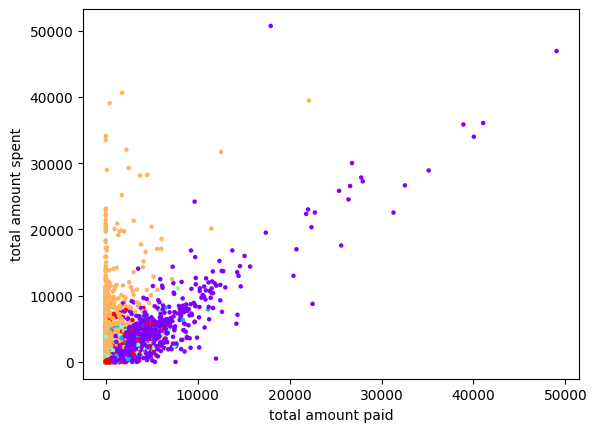

In [31]:
# 'labels' comes from clustering
# 's'
plt.scatter(df['PURCHASES'], df['PAYMENTS'], c=labels, s=5, cmap='rainbow' )
plt.xlabel("total amount paid")
plt.ylabel("total amount spent")
plt.show()

Two major clusters were generated with two predominant colors, purple and orange.

When we analyze the <font color='Orange'>orange cluster</font>, we notice that there is a tendency to draw a straight vertical line, which indicates that the total amount spent by customers is increasing, but the total amount paid does not follow this upward trend.

In general, what we can see is that the cluster represents customers who spent more, but didn't pay the bill or paid it partially.

The <font color='Purple'> purple cluster</font> shows a diagonal, which indicates that as the amount spent increases, so does the amount paid. This cluster represents customers who have paid their bill or almost paid it in full.

We have some interesting information, but that's not enough to understand the whole picture. We'll plot other dimensions, but always in pairs, so that we can interpret other attributes in a clear, visible way.

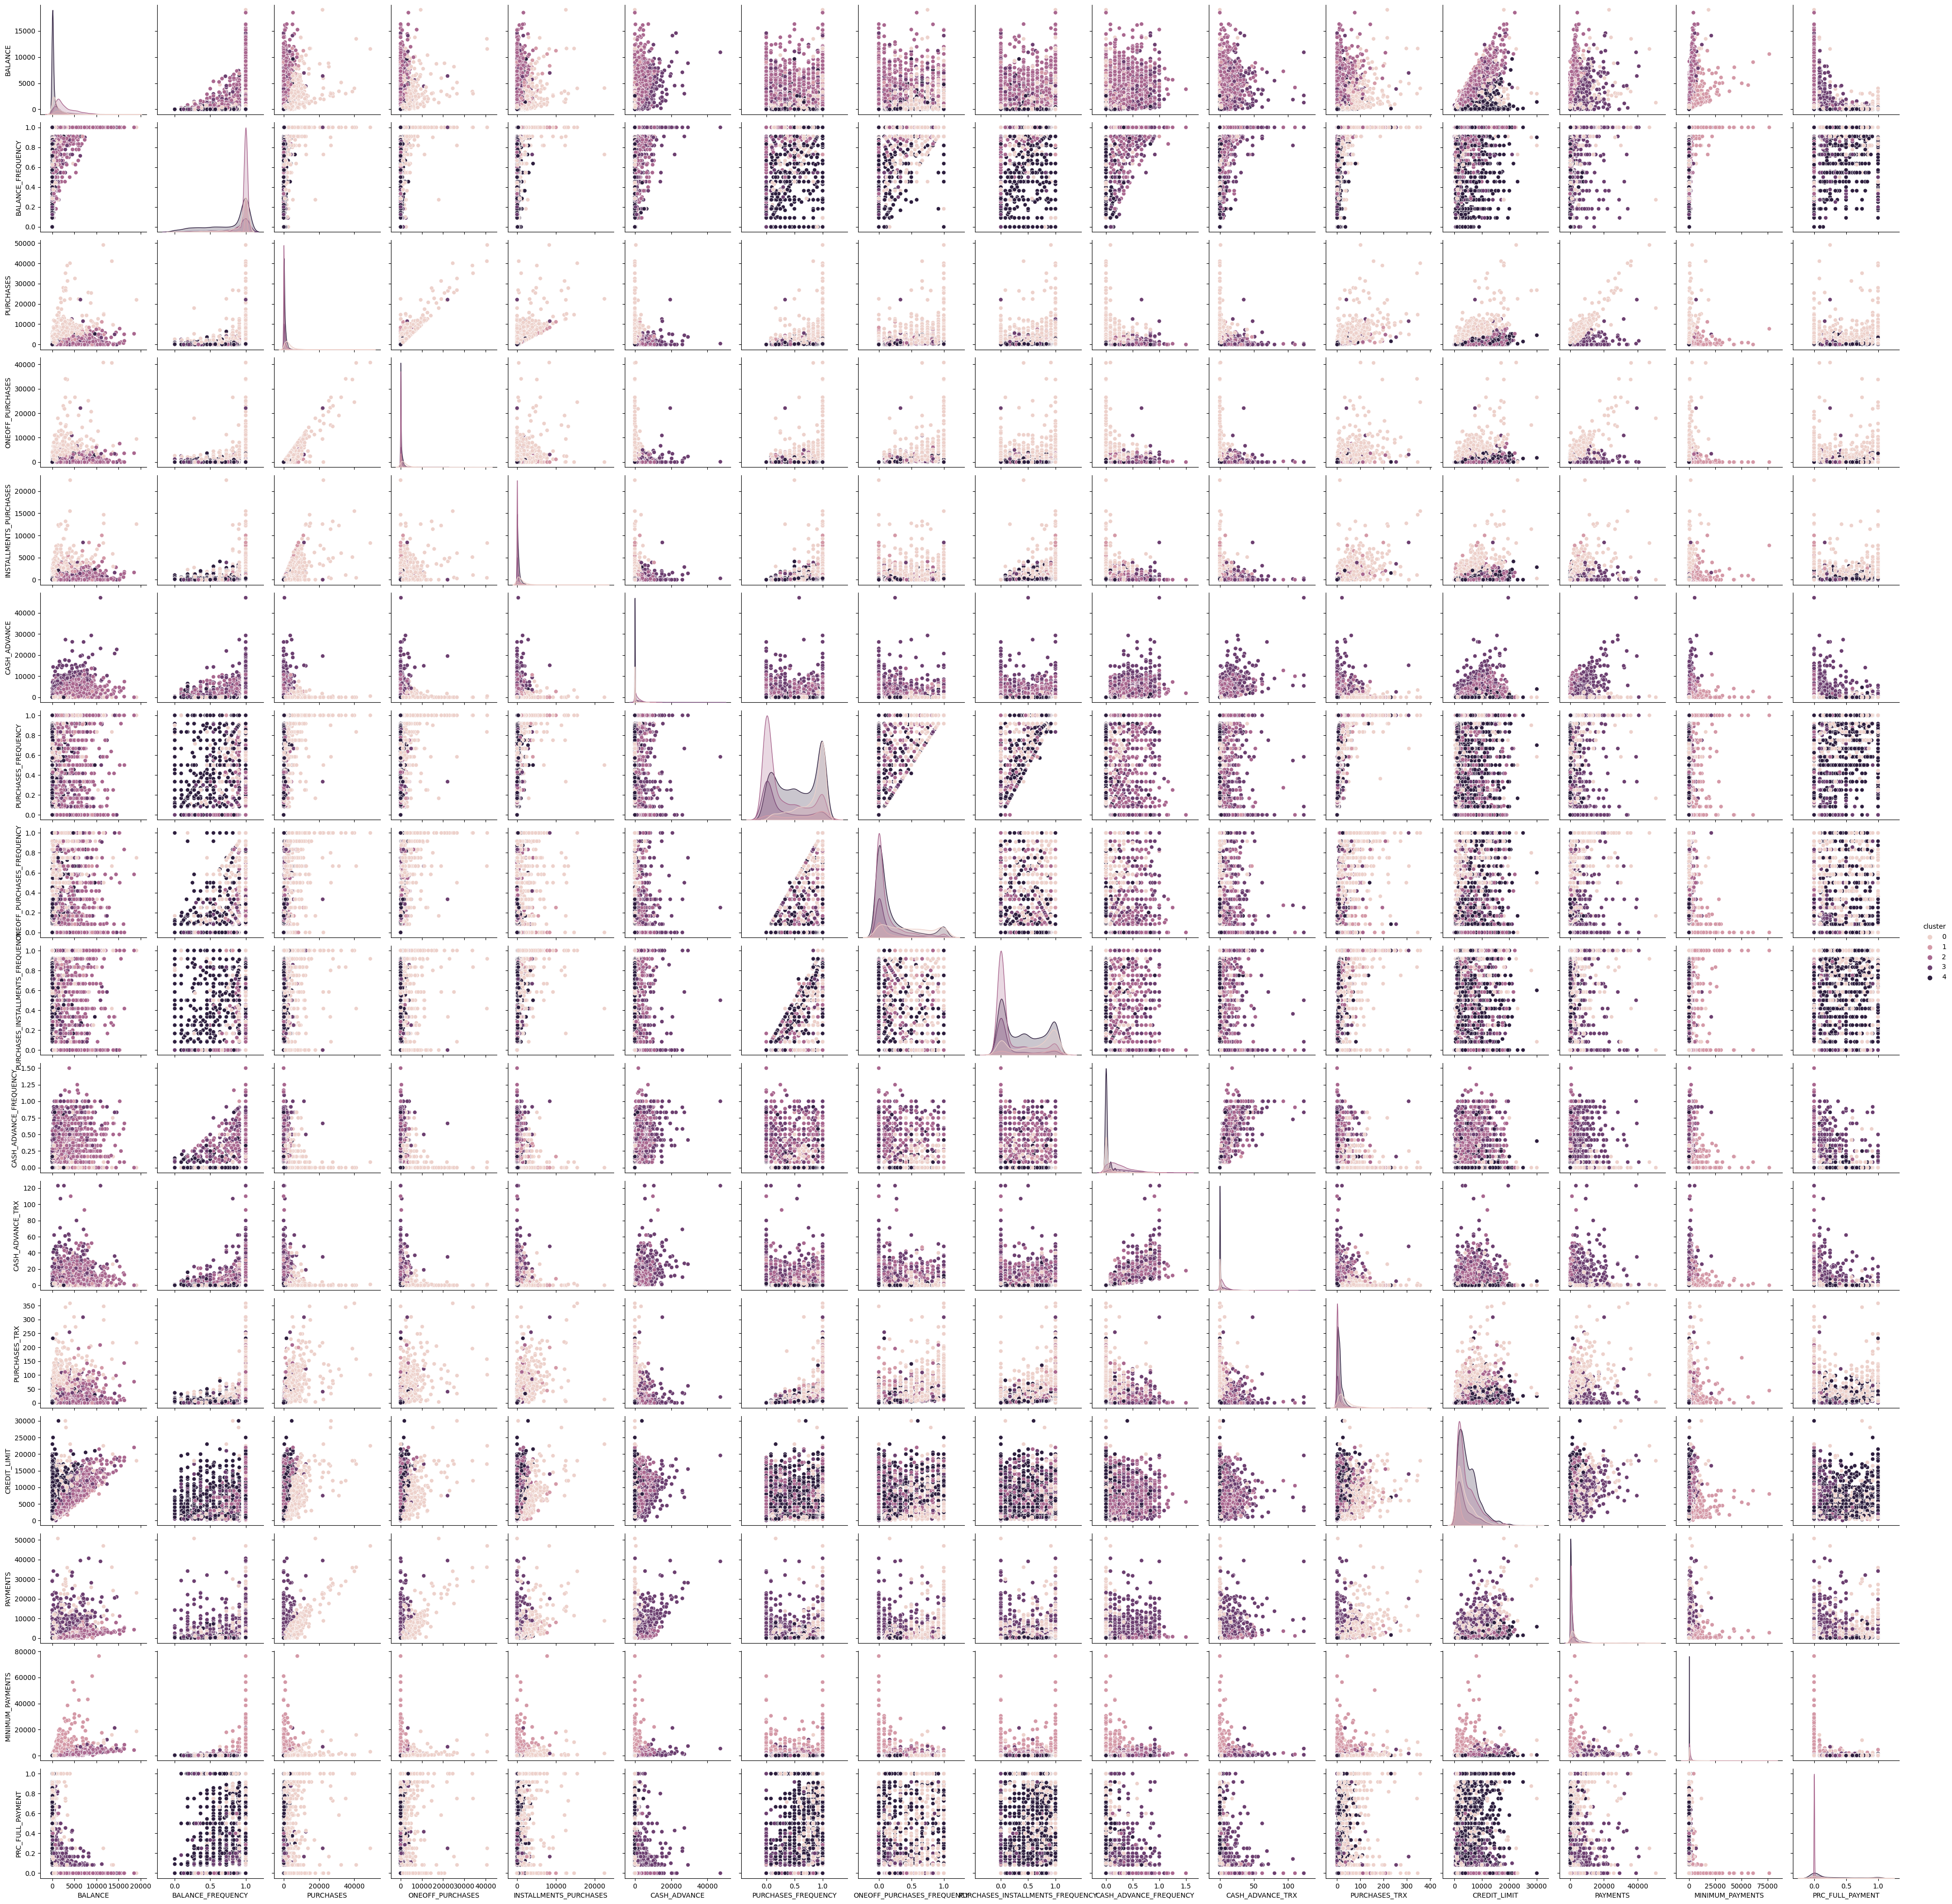

In [33]:
df["cluster"] = labels
sns.pairplot(df[0:], hue="cluster")

## Description

There are many attributes to analyze, so we will select some of the most significant ones. That's not to say that the others aren't important, but we'll need to do this sorting in order to carry out the analysis.

In [34]:
df.groupby("cluster").describe()

BALANCE                                                    \
          count         mean          std        min          25%   
cluster                                                             
0        1540.0  1142.222657  1664.035755   0.000000   211.566656   
1         411.0  1987.501586  1854.459156  70.794108  1018.958891   
2        2649.0  3037.962543  2478.838161   6.824905  1256.612223   
3        1072.0  1794.024195  1982.950586   0.000000   506.925348   
4        3278.0   443.992358   846.597972   0.000000    23.315538   

                                                BALANCE_FREQUENCY            \
                 50%          75%           max             count      mean   
cluster                                                                       
0         554.332740  1370.859355  19043.138560            1540.0  0.928053   
1        1337.287314  2138.678431  11670.179850             411.0  0.989486   
2        2174.018945  4223.867789  18495.558550            2649.0  0.963740   
3        1087.920500  2308.762488  14581.459140            1072.0  0.862131   
4          82.992153   411.193793   9630.367575            3278.0  0.774417   

         ... MINIMUM_PAYMENTS               PRC_FULL_PAYMENT            \
         ...              75%           max            count      mean   
cluster  ...                                                             
0        ...       524.184580  18621.013310           1540.0  0.278582   
1        ...      7112.618584  76406.207520            411.0  0.019318   
2        ...      1330.593643   8345.641905           2649.0  0.001799   
3        ...       884.718306  21235.065300           1072.0  0.117384   
4        ...       248.800040   4483.503862           3278.0  0.246549   

                                                      
              std  min  25%       50%       75%  max  
cluster                                               
0        0.367203  0.0  0.0  0.083333  0.545455  1.0  
1        0.090901  0.0  0.0  0.000000  0.000000  1.0  
2        0.023260  0.0  0.0  0.000000  0.000000  0.6  
3        0.186853  0.0  0.0  0.083333  0.142857  1.0  
4        0.346601  0.0  0.0  0.000000  0.444444  1.0  

[5 rows x 128 columns]

In [36]:
df.groupby('cluster').agg(['count','mean'])

BALANCE              BALANCE_FREQUENCY           PURCHASES  \
          count         mean             count      mean     count   
cluster                                                              
0          1540  1142.222657              1540  0.928053      1540   
1           411  1987.501586               411  0.989486       411   
2          2649  3037.962543              2649  0.963740      2649   
3          1072  1794.024195              1072  0.862131      1072   
4          3278   443.992358              3278  0.774417      3278   

                     ONEOFF_PURCHASES              INSTALLMENTS_PURCHASES  \
                mean            count         mean                  count   
cluster                                                                     
0        3268.886929             1540  2124.548591                   1540   
1         854.865815              411   184.572360                    411   
2         385.248630             2649   232.969339                   2649   
3         475.494823             1072   286.705942                   1072   
4         629.345171             3278   314.266580                   3278   

                      ... PURCHASES_TRX            CREDIT_LIMIT               \
                mean  ...         count       mean        count         mean   
cluster               ...                                                      
0        1144.954571  ...          1540  37.880519         1540  4097.701397   
1         671.135426  ...           411  17.579075          411  2227.737226   
2         152.368543  ...          2649   7.189128         2649  4495.771989   
3         188.841791  ...          1072   7.333022         1072  3976.372399   
4         315.413682  ...          3278  11.954545         3278  5132.945933   

        PAYMENTS              MINIMUM_PAYMENTS              PRC_FULL_PAYMENT  \
           count         mean            count         mean            count   
cluster                                                                        
0           1540  3037.241495             1540   541.946449             1540   
1            411  1336.238911              411  6042.286901              411   
2           2649   968.890376             2649  1022.143477             2649   
3           1072  4709.556601             1072   734.234709             1072   
4           3278   814.477150             3278   228.548028             3278   

                   
             mean  
cluster            
0        0.278582  
1        0.019318  
2        0.001799  
3        0.117384  
4        0.246549  

[5 rows x 32 columns]

## Analyzing the values

Strategy for selecting the most significant attribute and analyzing it:

We have the value of each of the 16 attributes of the 5 clusters. We will observe the variance of the centroids for a given attribute, i.e. we will collect an attribute and check how it behaves in the different clusters.

For example, if we take the first cluster with a value of 1.59699490e-01 for the first "BALANCE" attribute.

The next cluster will already be very different, and the same goes for the following ones.

Since we're going to analyze variance, we'll look for an attribute where the values are different between the clusters, so that we have a better chance of observing the particularities of each group.

For example, we can see that we have customers who spend a lot in one cluster and those who spend little in another. However, there may be some other attribute where the difference isn't significant and won't help or even hinder our interpretation.

So we'll use the variance calculation. <font color='RoyalBlue'>Those attributes with the greatest variance will be used.</font>

In [37]:
# selects the KMeans centroids of each of the clusters
centroids = kmeans.cluster_centers_
centroids

array([[1.59699490e-01, 2.45649360e-04, 4.38116859e-01, 2.56325660e-01,
        1.81962376e-01, 2.57889184e-02, 2.04826443e-04, 8.87914942e-05,
        1.51162866e-04, 9.36296056e-06, 1.69350945e-04, 6.17145756e-03,
        6.04336246e-01, 4.02584838e-01, 8.54128174e-02, 7.26645255e-05],
       [3.32918803e-01, 2.68423552e-04, 1.58240376e-01, 3.63059801e-02,
        1.22319068e-01, 5.83557153e-02, 1.66754597e-04, 2.64938445e-05,
        1.47063187e-04, 1.93217566e-05, 4.27934836e-04, 3.86197017e-03,
        3.76718873e-01, 2.51861450e-01, 6.80311114e-01, 4.23993819e-06],
       [5.04263792e-01, 2.72194282e-04, 6.17808431e-02, 3.62269020e-02,
        2.55756543e-02, 2.52903017e-01, 6.73170559e-05, 2.56975193e-05,
        4.50651626e-05, 5.74388410e-05, 1.15687334e-03, 1.33194105e-03,
        7.19174706e-01, 1.66205262e-01, 1.79245673e-01, 5.52303554e-07],
       [2.35141479e-01, 2.16555293e-04, 6.03857074e-02, 3.44170171e-02,
        2.59739049e-02, 4.00128071e-01, 5.26401668e-05, 2.048